## Pre-trained network (VGG 16)

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# display the convolutional base architecture details
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Basic feature extraction

In [3]:
import os

# deprecated, but works
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

base_dir = "./cats_and_dogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [4]:
import numpy as np

# function to extract the features
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    i = 0

    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1

        if i * batch_size >= sample_count:
            # note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break

    return features, labels

In [5]:
# creating training, validation & testing set
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━

### Defining densely connected classifier

In [6]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Input((4, 4, 512)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,097,665 (8.00 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

### Training & fitting the model

In [7]:
from keras import optimizers

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6201 - loss: 0.6558 - val_accuracy: 0.8070 - val_loss: 0.4605
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7965 - loss: 0.4697 - val_accuracy: 0.8630 - val_loss: 0.3719
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8294 - loss: 0.3868 - val_accuracy: 0.8790 - val_loss: 0.3313
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8574 - loss: 0.3235 - val_accuracy: 0.8730 - val_loss: 0.3187
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8540 - loss: 0.3348 - val_accuracy: 0.8880 - val_loss: 0.2885
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8874 - loss: 0.2788 - val_accuracy: 0.8870 - val_loss: 0.2768
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8942 - loss: 0.2603 - val_accuracy: 0.8880 - val_loss: 0.2723
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8942 - loss: 0.2653 - val_accuracy: 0.

### Plotting loss & accuracy curves

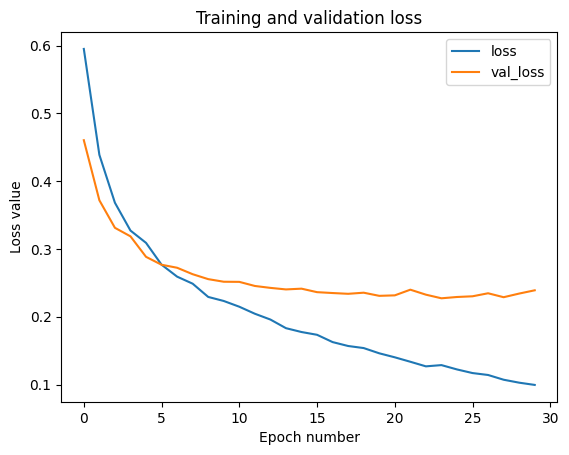

In [9]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.plot(history_dict['loss'], label='loss')
plt.plot(history_dict['val_loss'], label='val_loss')

plt.title('Training and validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss value')
plt.xticks([5*i for i in range(7)])
plt.legend()
plt.show()

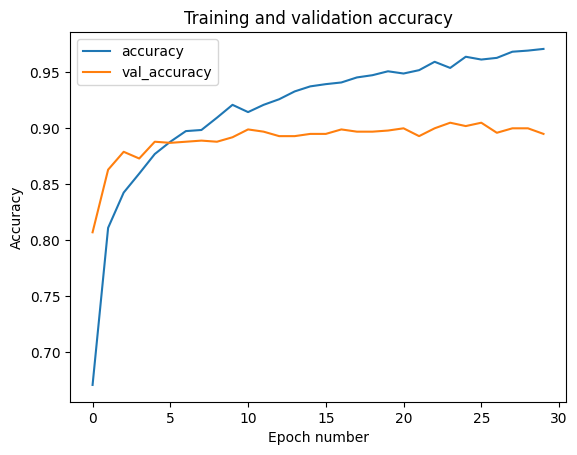

In [10]:
plt.plot(history_dict['accuracy'], label='accuracy')
plt.plot(history_dict['val_accuracy'], label='val_accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.xticks([5*i for i in range(7)])
plt.legend()
plt.show()

### Pre-trained part as an extended layer

In [11]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
print(
    'This is the number of trainable weights before freezing the conv base:',
    len(model2.trainable_weights)
)

conv_base.trainable = False

print(
    'This is the number of trainable weights after freezing the conv base:',
    len(model2.trainable_weights)
)

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


### Fitting the model

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# note that the validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # this is the target directory
    target_size=(150, 150), # all images will be resized to 150x150
    batch_size=20,
    class_mode='binary' # since we use binary_crossentropy loss, we need binary labels
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model2.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 - 21s - 209ms/step - accuracy: 0.6905 - loss: 0.5907 - val_accuracy: 0.8090 - val_loss: 0.4562
Epoch 2/30
100/100 - 18s - 179ms/step - accuracy: 0.7765 - loss: 0.4776 - val_accuracy: 0.8510 - val_loss: 0.3593
Epoch 3/30
100/100 - 19s - 188ms/step - accuracy: 0.8140 - loss: 0.4229 - val_accuracy: 0.8460 - val_loss: 0.3601
Epoch 4/30
100/100 - 17s - 174ms/step - accuracy: 0.8230 - loss: 0.4042 - val_accuracy: 0.8660 - val_loss: 0.3204
Epoch 5/30
100/100 - 18s - 176ms/step - accuracy: 0.8195 - loss: 0.3963 - val_accuracy: 0.8810 - val_loss: 0.2944
Epoch 6/30
100/100 - 18s - 176ms/step - accuracy: 0.8355 - loss: 0.3716 - val_accuracy: 0.8830 - val_loss: 0.2782
Epoch 7/30
100/100 - 18s - 179ms/step - accuracy: 0.8345 - loss: 0.3597 - val_accuracy: 0.8840 - val_loss: 0.2810
Epoch 8/30
100/100 - 18s - 182ms/step - accuracy: 0.8515 - loss: 0.3567 - val_accuracy: 0.8910 - val_loss: 0.2705
Epoch 9/30
100/100 - 18s - 180ms/step - accuracy: 0.8375 - loss: 0.3492 - val_accuracy: 

### Plotting the results

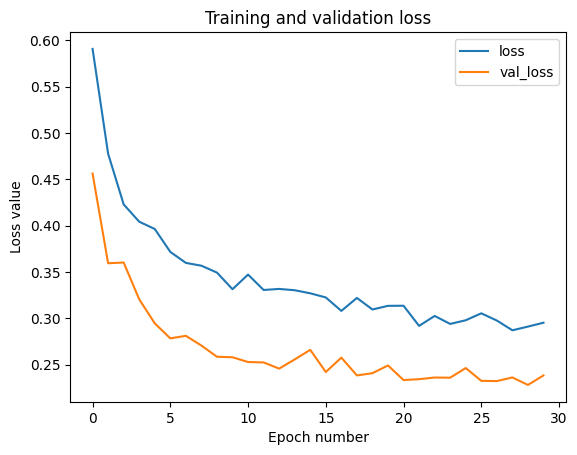

In [14]:
history2_dict = history2.history

plt.plot(history2_dict['loss'], label='loss')
plt.plot(history2_dict['val_loss'], label='val_loss')

plt.title('Training and validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss value')
plt.xticks([5*i for i in range(7)])
plt.legend()
plt.show()

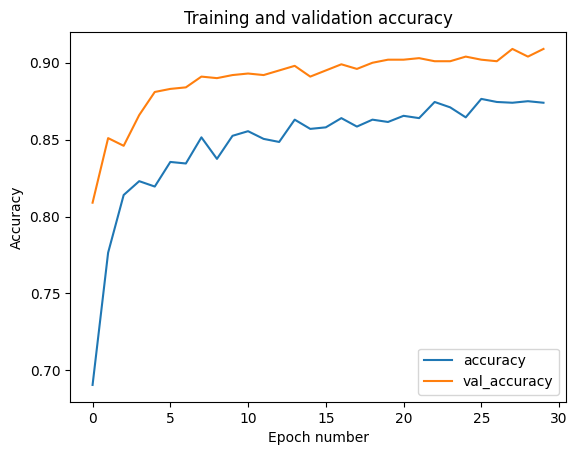

In [15]:
plt.plot(history2_dict['accuracy'], label='accuracy')
plt.plot(history2_dict['val_accuracy'], label='val_accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.xticks([5*i for i in range(7)])
plt.legend()
plt.show()

### Fine-tuning

In [16]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True

    layer.trainable = set_trainable

In [17]:
model2.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history3 = model2.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 208ms/step - accuracy: 0.8528 - loss: 0.3040 - val_accuracy: 0.9140 - val_loss: 0.2329
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.8883 - loss: 0.2612 - val_accuracy: 0.9250 - val_loss: 0.1959
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.8853 - loss: 0.2578 - val_accuracy: 0.9180 - val_loss: 0.2194
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9171 - loss: 0.1995 - val_accuracy: 0.9280 - val_loss: 0.1934
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.9026 - loss: 0.2142 - val_accuracy: 0.9300 - val_loss: 0.1834
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9194 - loss: 0.1867 - val_accuracy: 0.9300 - val_loss: 0.1820
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9248 - loss: 0.1915 - val_accuracy: 0.9220 - val_loss: 0.2195
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.9228 -

### Plotting the results

In [18]:
# function smoothing a curve in a plot
def smooth_curve(points, factor=0.8):
    smoothed_points = []

    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)

    return smoothed_points

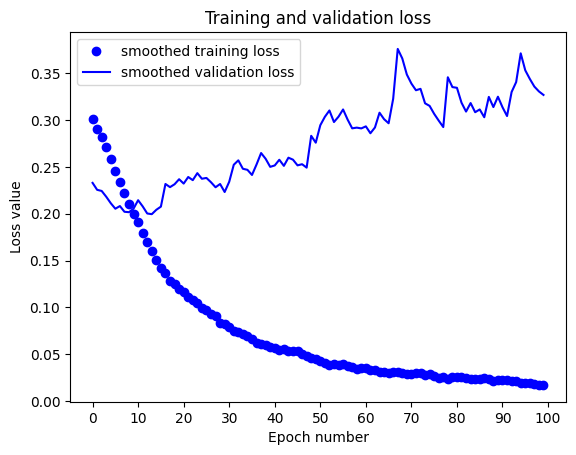

In [19]:
history3_dict = history3.history
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']
epochs = [i for i in range(len(loss))]

plt.plot(epochs, smooth_curve(loss), 'bo', label='smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='smoothed validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss value')
plt.xticks([10*i for i in range(11)])
plt.legend()
plt.show()

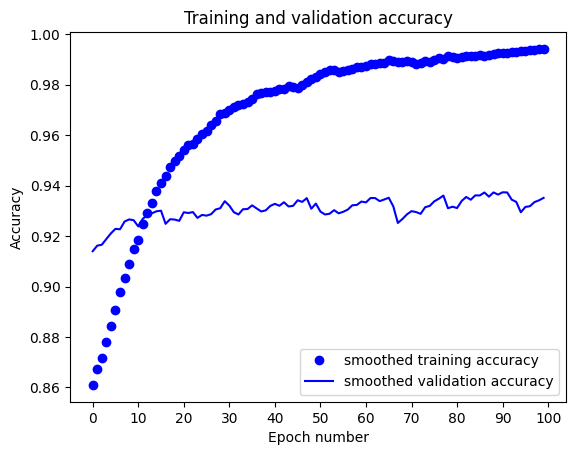

In [20]:
accuracy = history3_dict['accuracy']
val_accuracy = history3_dict['val_accuracy']

plt.plot(epochs, smooth_curve(accuracy), 'bo', label='smoothed training accuracy')
plt.plot(epochs, smooth_curve(val_accuracy), 'b', label='smoothed validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.xticks([10*i for i in range(11)])
plt.legend()
plt.show()

### Model evaluation

In [21]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model2.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9331 - loss: 0.3253
test acc: 0.9409999847412109
